In [5]:
import pathlib
# import json

# from attrs import define, field, evolve
# import polars as pl
import numpy as np
import matplotlib.pyplot as plt

from odbex.post import simdata

In [6]:
TEST_DATA = pathlib.Path('/home/michael_olaya_student_uml_edu/repos/odb-extractor/tests/raw_odbex/extracted_9elem_composite_cure_perm1_2cpu.json')

In [7]:
sd = simdata.SimulationData.from_extracted(TEST_DATA)
model_data = sd.get_region_data('cure-step', 'SET-ALLELEMENTS')
stress = model_data.volume_average_field('S')
strain = model_data.volume_average_field('E')

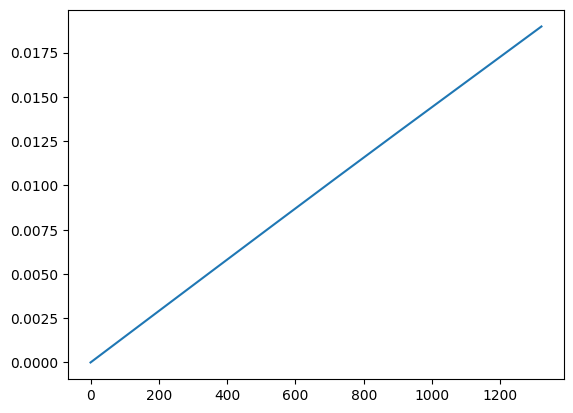

In [8]:
fig, ax = plt.subplots()
ax.plot(model_data.field_data['E'].increments.values(), strain.data[:, 1])